In [1]:
!pip install ../input/efficientnettfkeras/efficientnet-master

Processing /kaggle/input/efficientnettfkeras/efficientnet-master
  Created wheel for efficientnet: filename=efficientnet-1.1.0-cp36-none-any.whl size=18328 sha256=e383409f9c1780b793b3146ddffeaf39d0f342ee98c257b1294f474a34cde62b
  Stored in directory: /root/.cache/pip/wheels/60/99/7a/0d26ac8df8ca7b42784e5bf2dc85c0b35e37567de8eef7310c
Successfully built efficientnet


# Import Libraries

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras as keras
import cv2
import glob
from tqdm.notebook import tqdm
import numpy as np
import os
import efficientnet.tfkeras as efn
from tensorflow.keras.layers import *
from tensorflow.keras import Model
import matplotlib.pyplot as plt

In [3]:
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

# Initialize Face Extractor

In [4]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.io.gfile.GFile('../input/mobilenet-face/frozen_inference_graph_face.pb', 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [5]:
cm = detection_graph.as_default()
cm.__enter__()

In [6]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(graph=detection_graph, config=config)
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
boxes_tensor = detection_graph.get_tensor_by_name('detection_boxes:0')
scores_tensor = detection_graph.get_tensor_by_name('detection_scores:0')
num_detections = detection_graph.get_tensor_by_name('num_detections:0')

In [7]:
def get_img(images):
    global boxes,scores,num_detections
    im_heights,im_widths=[],[]
    imgs=[]
    for image in images:
        (im_height,im_width)=image.shape[:-1]
        imgs.append(image)
        im_heights.append(im_height)
        im_widths.append(im_widths)
    imgs=np.array(imgs)
    (boxes, scores_) = sess.run(
        [boxes_tensor, scores_tensor],
        feed_dict={image_tensor: imgs})
    finals=[]
    for x in range(boxes.shape[0]):
        scores=scores_[x]
        max_=np.where(scores==scores.max())[0][0]
        box=boxes[x][max_]
        ymin, xmin, ymax, xmax = box
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                      ymin * im_height, ymax * im_height)
        left, right, top, bottom = int(left), int(right), int(top), int(bottom)
        image=imgs[x]
        finals.append(cv2.cvtColor(cv2.resize(
            image[max([0,top-40]):bottom+80,max([0,left-40]):right+80],(240,240)),cv2.COLOR_BGR2RGB))
    return finals
def detect_video(video):
    frame_count=10
    capture = cv2.VideoCapture(video)
    v_len = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_idxs = np.linspace(0,v_len,frame_count, endpoint=False, dtype=np.int)
    imgs=[]
    i=0
    for frame_idx in range(int(v_len)):
        ret = capture.grab()
        if not ret: 
            print("Error grabbing frame %d from movie %s" % (frame_idx, video))
        if frame_idx >= frame_idxs[i]:
            if frame_idx-frame_idxs[i]>20:
                return None
            ret, frame = capture.retrieve()
            if not ret or frame is None:
                print("Error retrieving frame %d from movie %s" % (frame_idx, video))
            else:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                imgs.append(frame)
            i += 1
            if i >= len(frame_idxs):
                break
    imgs=get_img(imgs)
    if len(imgs)<10:
        return None
    return np.hstack(imgs)


In [8]:
os.mkdir('./videos/')
for x in tqdm(glob.glob('../input/deepfake-detection-challenge/test_videos/*.mp4')):
    try:
        filename=x.replace('../input/deepfake-detection-challenge/test_videos/','').replace('.mp4','.jpg')
        a=detect_video(x)
        if a is None:
            continue
        cv2.imwrite('./videos/'+filename,a)
    except Exception as err:
        print(err)

In [9]:
cm.__exit__(None,Exception,'exit')
sess.close()

In [10]:
del sess

In [11]:
tf.keras.backend.clear_session()

In [12]:
import gc
gc.collect()

401

# Initialize Model

In [13]:
from keras import backend as K
class SeqSelfAttention(tf.keras.layers.Layer):

    ATTENTION_TYPE_ADD = 'additive'
    ATTENTION_TYPE_MUL = 'multiplicative'

    def __init__(self,
                 units=32,
                 attention_width=None,
                 attention_type=ATTENTION_TYPE_ADD,
                 return_attention=False,
                 history_only=False,
                 kernel_initializer='glorot_normal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 use_additive_bias=True,
                 use_attention_bias=True,
                 attention_activation=None,
                 attention_regularizer_weight=0.0,
                 **kwargs):
        """Layer initialization.
        For additive attention, see: https://arxiv.org/pdf/1806.01264.pdf
        :param units: The dimension of the vectors that used to calculate the attention weights.
        :param attention_width: The width of local attention.
        :param attention_type: 'additive' or 'multiplicative'.
        :param return_attention: Whether to return the attention weights for visualization.
        :param history_only: Only use historical pieces of data.
        :param kernel_initializer: The initializer for weight matrices.
        :param bias_initializer: The initializer for biases.
        :param kernel_regularizer: The regularization for weight matrices.
        :param bias_regularizer: The regularization for biases.
        :param kernel_constraint: The constraint for weight matrices.
        :param bias_constraint: The constraint for biases.
        :param use_additive_bias: Whether to use bias while calculating the relevance of inputs features
                                  in additive mode.
        :param use_attention_bias: Whether to use bias while calculating the weights of attention.
        :param attention_activation: The activation used for calculating the weights of attention.
        :param attention_regularizer_weight: The weights of attention regularizer.
        :param kwargs: Parameters for parent class.
        """
        super(SeqSelfAttention, self).__init__(**kwargs)
        self.supports_masking = True
        self.units = units
        self.attention_width = attention_width
        self.attention_type = attention_type
        self.return_attention = return_attention
        self.history_only = history_only
        if history_only and attention_width is None:
            self.attention_width = int(1e9)

        self.use_additive_bias = use_additive_bias
        self.use_attention_bias = use_attention_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)
        self.kernel_constraint = keras.constraints.get(kernel_constraint)
        self.bias_constraint = keras.constraints.get(bias_constraint)
        self.attention_activation = keras.activations.get(attention_activation)
        self.attention_regularizer_weight = attention_regularizer_weight
        self._backend = keras.backend.backend()

        if attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            self.Wx, self.Wt, self.bh = None, None, None
            self.Wa, self.ba = None, None
        elif attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            self.Wa, self.ba = None, None
        else:
            raise NotImplementedError('No implementation for attention type : ' + attention_type)

    def get_config(self):
        config = {
            'units': self.units,
            'attention_width': self.attention_width,
            'attention_type': self.attention_type,
            'return_attention': self.return_attention,
            'history_only': self.history_only,
            'use_additive_bias': self.use_additive_bias,
            'use_attention_bias': self.use_attention_bias,
            'kernel_initializer': keras.initializers.serialize(self.kernel_initializer),
            'bias_initializer': keras.initializers.serialize(self.bias_initializer),
            'kernel_regularizer': keras.regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': keras.regularizers.serialize(self.bias_regularizer),
            'kernel_constraint': keras.constraints.serialize(self.kernel_constraint),
            'bias_constraint': keras.constraints.serialize(self.bias_constraint),
            'attention_activation': keras.activations.serialize(self.attention_activation),
            'attention_regularizer_weight': self.attention_regularizer_weight,
        }
        base_config = super(SeqSelfAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        if self.attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            self._build_additive_attention(input_shape)
        elif self.attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            self._build_multiplicative_attention(input_shape)
        super(SeqSelfAttention, self).build(input_shape)

    def _build_additive_attention(self, input_shape):
        feature_dim = int(input_shape[2])

        self.Wt = self.add_weight(shape=(feature_dim, self.units),
                                  name='{}_Add_Wt'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        self.Wx = self.add_weight(shape=(feature_dim, self.units),
                                  name='{}_Add_Wx'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_additive_bias:
            self.bh = self.add_weight(shape=(self.units,),
                                      name='{}_Add_bh'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

        self.Wa = self.add_weight(shape=(self.units, 1),
                                  name='{}_Add_Wa'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_attention_bias:
            self.ba = self.add_weight(shape=(1,),
                                      name='{}_Add_ba'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

    def _build_multiplicative_attention(self, input_shape):
        feature_dim = int(input_shape[2])

        self.Wa = self.add_weight(shape=(feature_dim, feature_dim),
                                  name='{}_Mul_Wa'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_attention_bias:
            self.ba = self.add_weight(shape=(1,),
                                      name='{}_Mul_ba'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

    def call(self, inputs, mask=None, **kwargs):
        input_len = K.shape(inputs)[1]

        if self.attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            e = self._call_additive_emission(inputs)
        elif self.attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            e = self._call_multiplicative_emission(inputs)

        if self.attention_activation is not None:
            e = self.attention_activation(e)
        e = K.exp(e - K.max(e, axis=-1, keepdims=True))
        if self.attention_width is not None:
            if self.history_only:
                lower = K.arange(0, input_len) - (self.attention_width - 1)
            else:
                lower = K.arange(0, input_len) - self.attention_width // 2
            lower = K.expand_dims(lower, axis=-1)
            upper = lower + self.attention_width
            indices = K.expand_dims(K.arange(0, input_len), axis=0)
            e = e * K.cast(lower <= indices, K.floatx()) * K.cast(indices < upper, K.floatx())
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            mask = K.expand_dims(mask)
            e = K.permute_dimensions(K.permute_dimensions(e * mask, (0, 2, 1)) * mask, (0, 2, 1))

        # a_{t} = \text{softmax}(e_t)
        s = K.sum(e, axis=-1, keepdims=True)
        a = e / (s + K.epsilon())

        # l_t = \sum_{t'} a_{t, t'} x_{t'}
        v = K.batch_dot(a, inputs)
        if self.attention_regularizer_weight > 0.0:
            self.add_loss(self._attention_regularizer(a))

        if self.return_attention:
            return [v, a]
        return v

    def _call_additive_emission(self, inputs):
        input_shape = K.shape(inputs)
        batch_size, input_len = input_shape[0], input_shape[1]

        # h_{t, t'} = \tanh(x_t^T W_t + x_{t'}^T W_x + b_h)
        q = K.expand_dims(K.dot(inputs, self.Wt), 2)
        k = K.expand_dims(K.dot(inputs, self.Wx), 1)
        if self.use_additive_bias:
            h = K.tanh(q + k + self.bh)
        else:
            h = K.tanh(q + k)

        # e_{t, t'} = W_a h_{t, t'} + b_a
        if self.use_attention_bias:
            e = K.reshape(K.dot(h, self.Wa) + self.ba, (batch_size, input_len, input_len))
        else:
            e = K.reshape(K.dot(h, self.Wa), (batch_size, input_len, input_len))
        return e

    def _call_multiplicative_emission(self, inputs):
        # e_{t, t'} = x_t^T W_a x_{t'} + b_a
        e = K.batch_dot(K.dot(inputs, self.Wa), K.permute_dimensions(inputs, (0, 2, 1)))
        if self.use_attention_bias:
            e += self.ba[0]
        return e

    def compute_output_shape(self, input_shape):
        output_shape = input_shape
        if self.return_attention:
            attention_shape = (input_shape[0], output_shape[1], input_shape[1])
            return [output_shape, attention_shape]
        return output_shape

    def compute_mask(self, inputs, mask=None):
        if self.return_attention:
            return [mask, None]
        return mask

    def _attention_regularizer(self, attention):
        batch_size = K.cast(K.shape(attention)[0], K.floatx())
        input_len = K.shape(attention)[-1]
        indices = K.expand_dims(K.arange(0, input_len), axis=0)
        diagonal = K.expand_dims(K.arange(0, input_len), axis=-1)
        eye = K.cast(K.equal(indices, diagonal), K.floatx())
        return self.attention_regularizer_weight * K.sum(K.square(K.batch_dot(
            attention,
            K.permute_dimensions(attention, (0, 2, 1))) - eye)) / batch_size

    @staticmethod
    def get_custom_objects():
        return {'SeqSelfAttention': SeqSelfAttention}

Using TensorFlow backend.


In [14]:
def create_B1model():
    bottleneck = efn.EfficientNetB1(weights=None,include_top=False,pooling='avg')
    inp=Input((10,240,240,3))
    x=TimeDistributed(bottleneck)(inp)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = SeqSelfAttention(attention_activation='sigmoid')(x)
    x = Dense(64, activation='elu')(x)
    x = Dense(1,activation='sigmoid')(x)
    model=Model(inp,x)
    model.summary()
    return model

def create_B2model():
    bottleneck = efn.EfficientNetB2(weights=None,include_top=False,pooling='avg')
    inp=Input((10,240,240,3))
    x=TimeDistributed(bottleneck)(inp)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = SeqSelfAttention(attention_activation='sigmoid')(x)
    x = Dense(64, activation='elu')(x)
    x = Dense(1,activation='sigmoid')(x)
    model=Model(inp,x)
    model.summary()
    return model

In [15]:
model1 = create_B2model()
model1.load_weights('../input/tcnnaws/TCNN-AWS-B2f1.08-0.1526.hdf5')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10, 240, 240, 3)] 0         
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 1408)          7768562   
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 256)           1573888   
_________________________________________________________________
seq_self_attention (SeqSelfA (None, None, 256)         16449     
_________________________________________________________________
dense (Dense)                (None, None, 64)          16448     
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           65        
Total params: 9,375,412
Trainable params: 9,307,844
Non-trainable params: 67,568
______________________________________________

In [16]:
model2 = create_B2model()
model2.load_weights('../input/tcnnaws/TCNN-AWS-B2f2-cc.01-0.1566.hdf5')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10, 240, 240, 3)] 0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 1408)          7768562   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10, 256)           1573888   
_________________________________________________________________
seq_self_attention_1 (SeqSel (None, None, 256)         16449     
_________________________________________________________________
dense_2 (Dense)              (None, None, 64)          16448     
_________________________________________________________________
dense_3 (Dense)              (None, None, 1)           65        
Total params: 9,375,412
Trainable params: 9,307,844
Non-trainable params: 67,568
____________________________________________

In [17]:
model3 = create_B2model()
model3.load_weights('../input/tcnnaws/TCNN-AWS-B2f3.09-0.1560.hdf5')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 10, 240, 240, 3)] 0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 1408)          7768562   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 10, 256)           1573888   
_________________________________________________________________
seq_self_attention_2 (SeqSel (None, None, 256)         16449     
_________________________________________________________________
dense_4 (Dense)              (None, None, 64)          16448     
_________________________________________________________________
dense_5 (Dense)              (None, None, 1)           65        
Total params: 9,375,412
Trainable params: 9,307,844
Non-trainable params: 67,568
____________________________________________

In [18]:
model4 = create_B2model()
model4.load_weights('../input/tcnnaws/TCNN-AWS-B2f4.12-0.1484.hdf5')

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 10, 240, 240, 3)] 0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 1408)          7768562   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 10, 256)           1573888   
_________________________________________________________________
seq_self_attention_3 (SeqSel (None, None, 256)         16449     
_________________________________________________________________
dense_6 (Dense)              (None, None, 64)          16448     
_________________________________________________________________
dense_7 (Dense)              (None, None, 1)           65        
Total params: 9,375,412
Trainable params: 9,307,844
Non-trainable params: 67,568
____________________________________________

In [19]:
model5 = create_B2model()
model5.load_weights('../input/tcnnaws/TCNN-AWS-B2f5.06-0.1671.hdf5')

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 10, 240, 240, 3)] 0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 1408)          7768562   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 10, 256)           1573888   
_________________________________________________________________
seq_self_attention_4 (SeqSel (None, None, 256)         16449     
_________________________________________________________________
dense_8 (Dense)              (None, None, 64)          16448     
_________________________________________________________________
dense_9 (Dense)              (None, None, 1)           65        
Total params: 9,375,412
Trainable params: 9,307,844
Non-trainable params: 67,568
____________________________________________

In [20]:
model6 = create_B2model()
model6.load_weights('../input/tcnnaws/efficientnetB2f1-biLSTM-aug.10-0.1812.hdf5')

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 10, 240, 240, 3)] 0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 10, 1408)          7768562   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 10, 256)           1573888   
_________________________________________________________________
seq_self_attention_5 (SeqSel (None, None, 256)         16449     
_________________________________________________________________
dense_10 (Dense)             (None, None, 64)          16448     
_________________________________________________________________
dense_11 (Dense)             (None, None, 1)           65        
Total params: 9,375,412
Trainable params: 9,307,844
Non-trainable params: 67,568
____________________________________________

In [21]:
model7 = create_B2model()
model7.load_weights('../input/tcnnaws/TCNN-AWS-B2f2-aug-c.07-0.1667.hdf5')

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 10, 240, 240, 3)] 0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 10, 1408)          7768562   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 10, 256)           1573888   
_________________________________________________________________
seq_self_attention_6 (SeqSel (None, None, 256)         16449     
_________________________________________________________________
dense_12 (Dense)             (None, None, 64)          16448     
_________________________________________________________________
dense_13 (Dense)             (None, None, 1)           65        
Total params: 9,375,412
Trainable params: 9,307,844
Non-trainable params: 67,568
____________________________________________

In [22]:
model8 = create_B2model()
model8.load_weights('../input/tcnnaws/efficientnetB2f3-biLSTM-aug.09-0.1858.hdf5')

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 10, 240, 240, 3)] 0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 10, 1408)          7768562   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 10, 256)           1573888   
_________________________________________________________________
seq_self_attention_7 (SeqSel (None, None, 256)         16449     
_________________________________________________________________
dense_14 (Dense)             (None, None, 64)          16448     
_________________________________________________________________
dense_15 (Dense)             (None, None, 1)           65        
Total params: 9,375,412
Trainable params: 9,307,844
Non-trainable params: 67,568
____________________________________________

In [23]:
model9 = create_B2model()
model9.load_weights('../input/tcnnaws/efficientnetB2f4-biLSTM-aug.01-0.1834.hdf5')

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 10, 240, 240, 3)] 0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 10, 1408)          7768562   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 10, 256)           1573888   
_________________________________________________________________
seq_self_attention_8 (SeqSel (None, None, 256)         16449     
_________________________________________________________________
dense_16 (Dense)             (None, None, 64)          16448     
_________________________________________________________________
dense_17 (Dense)             (None, None, 1)           65        
Total params: 9,375,412
Trainable params: 9,307,844
Non-trainable params: 67,568
____________________________________________

In [24]:
model10 = create_B2model()
model10.load_weights('../input/tcnnaws/TCNN-AWS-B2f5-aug.13-0.1662.hdf5')

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 10, 240, 240, 3)] 0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 10, 1408)          7768562   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 10, 256)           1573888   
_________________________________________________________________
seq_self_attention_9 (SeqSel (None, None, 256)         16449     
_________________________________________________________________
dense_18 (Dense)             (None, None, 64)          16448     
_________________________________________________________________
dense_19 (Dense)             (None, None, 1)           65        
Total params: 9,375,412
Trainable params: 9,307,844
Non-trainable params: 67,568
____________________________________________

In [25]:
model11 = create_B1model()
model11.load_weights('../input/tcnnaws/TCNN-AWS4.09-0.1872.hdf5')

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 10, 240, 240, 3)] 0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 10, 1280)          6575232   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 10, 256)           1442816   
_________________________________________________________________
seq_self_attention_10 (SeqSe (None, None, 256)         16449     
_________________________________________________________________
dense_20 (Dense)             (None, None, 64)          16448     
_________________________________________________________________
dense_21 (Dense)             (None, None, 1)           65        
Total params: 8,051,010
Trainable params: 7,988,962
Non-trainable params: 62,048
___________________________________________

In [26]:
model12 = create_B1model()
model12.load_weights('../input/tcnnaws/TCNN-AWS-f2.07-0.1875.hdf5')

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 10, 240, 240, 3)] 0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 10, 1280)          6575232   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 10, 256)           1442816   
_________________________________________________________________
seq_self_attention_11 (SeqSe (None, None, 256)         16449     
_________________________________________________________________
dense_22 (Dense)             (None, None, 64)          16448     
_________________________________________________________________
dense_23 (Dense)             (None, None, 1)           65        
Total params: 8,051,010
Trainable params: 7,988,962
Non-trainable params: 62,048
___________________________________________

In [27]:
model13 = create_B1model()
model13.load_weights('../input/tcnnaws/TCNN-AWS-f3.12-0.1820.hdf5')

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 10, 240, 240, 3)] 0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 10, 1280)          6575232   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 10, 256)           1442816   
_________________________________________________________________
seq_self_attention_12 (SeqSe (None, None, 256)         16449     
_________________________________________________________________
dense_24 (Dense)             (None, None, 64)          16448     
_________________________________________________________________
dense_25 (Dense)             (None, None, 1)           65        
Total params: 8,051,010
Trainable params: 7,988,962
Non-trainable params: 62,048
___________________________________________

In [28]:
model14 = create_B1model()
model14.load_weights('../input/tcnnaws/TCNN-AWS-f3.09-0.1742.hdf5')

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 10, 240, 240, 3)] 0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 10, 1280)          6575232   
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 10, 256)           1442816   
_________________________________________________________________
seq_self_attention_13 (SeqSe (None, None, 256)         16449     
_________________________________________________________________
dense_26 (Dense)             (None, None, 64)          16448     
_________________________________________________________________
dense_27 (Dense)             (None, None, 1)           65        
Total params: 8,051,010
Trainable params: 7,988,962
Non-trainable params: 62,048
___________________________________________

In [29]:
models = [model1, model2, model3, model4, model5, model6, model7, model8, model9, model10, model11, model12, model13, model14]

In [30]:
def get_birghtness(img):
    return img/img.max()

# %% [code]
def process_img(img,flip=False):
    imgs=[]
    for x in range(10):
        if flip:
            imgs.append(get_birghtness(cv2.flip(img[:,x*240:(x+1)*240,:],1)))
        else:
            imgs.append(get_birghtness(img[:,x*240:(x+1)*240,:]))
    return np.array(imgs)

In [31]:
sample_submission = pd.read_csv("../input/deepfake-detection-challenge/sample_submission.csv")
test_files=glob.glob('./videos/*.jpg')
submission=pd.DataFrame()
submission['filename']=os.listdir(('../input/deepfake-detection-challenge/test_videos/'))
submission['label']=0.5
filenames=[]
batch=[]
batch1=[]
preds=[]
i = 0

In [32]:
for x in tqdm(test_files):
 
    img=process_img(cv2.cvtColor(cv2.imread(x),cv2.COLOR_BGR2RGB))
    if img is None:
        continue
    batch.append(img)
    batch1.append(process_img(cv2.cvtColor(cv2.imread(x),cv2.COLOR_BGR2RGB),True))
    filenames.append(x.replace('./videos/','').replace('.jpg','.mp4'))
    if len(batch)==16:
        result = 0
        for model in models:
            result += (model.predict(np.array(batch))+model.predict(np.array(batch1)))
        preds+=(result/(2*len(models))).tolist()
        #preds+=((model.predict(np.array(batch)))).tolist()
        batch=[]
        batch1=[]
        del result
    if i % 10 == 0 and i // 10 > 0:
        gc.collect()
        print(f'clear-{i}')
    i += 1
if len(batch)!=0:
    result = 0
    for model in models:
        result += (model.predict(np.array(batch))+model.predict(np.array(batch1)))
    preds+=(result/(2*len(models))).tolist()
    #preds+=((model.predict(np.array(batch)))).tolist()

clear-10
clear-20
clear-30
clear-40
clear-50
clear-60
clear-70
clear-80
clear-90
clear-100
clear-110
clear-120
clear-130
clear-140
clear-150
clear-160
clear-170
clear-180
clear-190
clear-200
clear-210
clear-220
clear-230
clear-240
clear-250
clear-260
clear-270
clear-280
clear-290
clear-300
clear-310
clear-320
clear-330
clear-340
clear-350
clear-360
clear-370
clear-380
clear-390



In [33]:
gc.collect()

4820

In [34]:
new_preds=[]
for x in preds:
    new_preds.append(x[0][0])
print(sum(new_preds)/len(new_preds))

0.519886860253755


In [35]:
for x,y in zip(new_preds,filenames):
    submission.loc[submission['filename']==y,'label']=min([max([0.01,x]),0.99])

(array([106.,  42.,  18.,  11.,   6.,   3.,   5.,   5.,   2.,   1.,   4.,
          5.,   0.,   0.,   1.,   4.,   3.,   7.,  16., 161.]),
 array([0.01 , 0.059, 0.108, 0.157, 0.206, 0.255, 0.304, 0.353, 0.402,
        0.451, 0.5  , 0.549, 0.598, 0.647, 0.696, 0.745, 0.794, 0.843,
        0.892, 0.941, 0.99 ]),
 <a list of 20 Patch objects>)

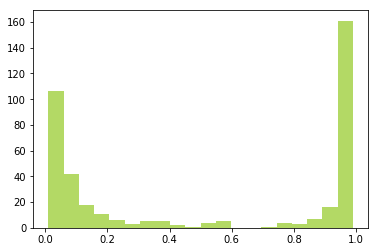

In [36]:
plt.hist(submission['label'],20,histtype = 'bar', facecolor = 'yellowgreen',alpha=0.75)

In [37]:
submission

,filename,label
0,nymodlmxni.mp4,0.052544
1,oaguiggjyv.mp4,0.010000
2,bdshuoldwx.mp4,0.966336
3,fwykevubzy.mp4,0.179550
4,mllzkpgatp.mp4,0.980953
...,...,...
395,pqthmvwonf.mp4,0.981431
396,xugmhbetrw.mp4,0.029129
397,orekjthsef.mp4,0.965992
398,yhjlnisfel.mp4,0.029527


In [38]:
np.array(submission['label']).mean()

0.5185351888186298

In [39]:
submission.to_csv('submission.csv', index=False)

In [40]:
! rm -r videos

Thanks for reading. Please upvote if you found it helpful.